# loading data

In [5]:
import pandas as pd
import numpy as np

import re

from scipy import stats
from scipy.special import boxcox1p

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
!ls

In [7]:
train_data = pd.read_excel('Data_Train.xlsx')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


## EDA

In [8]:
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


It can be noted that `Arrival_Time` column has dates(in some columns) that doesn't match the dates in `Date_of_Journey` column.

In [9]:
train_data.loc[:10,["Date_of_Journey", "Dep_Time", "Arrival_Time"]]

,Date_of_Journey,Dep_Time,Arrival_Time
0,24/03/2019,22:20,01:10 22 Mar
1,1/05/2019,05:50,13:15
2,9/06/2019,09:25,04:25 10 Jun
3,12/05/2019,18:05,23:30
4,01/03/2019,16:50,21:35
5,24/06/2019,09:00,11:25
6,12/03/2019,18:55,10:25 13 Mar
7,01/03/2019,08:00,05:05 02 Mar
8,12/03/2019,08:55,10:25 13 Mar
9,27/05/2019,11:25,19:15


let's see how each column affects the target column.

In [10]:
train_data.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')

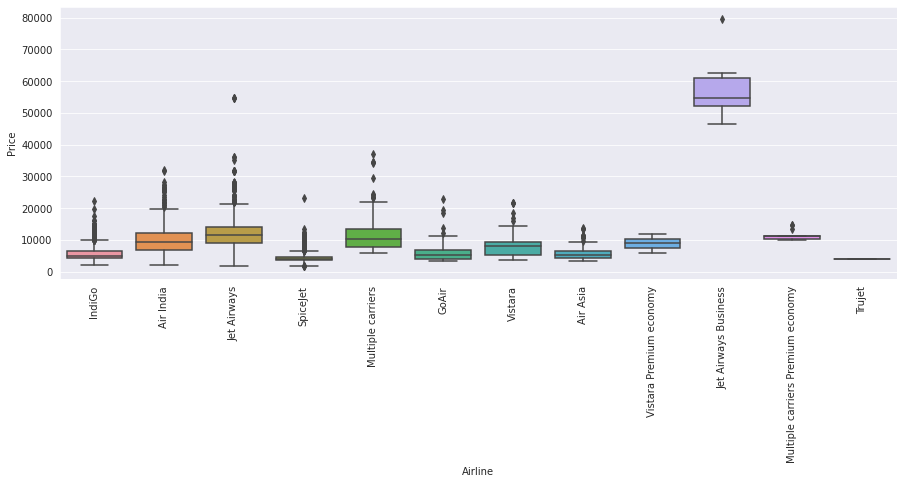

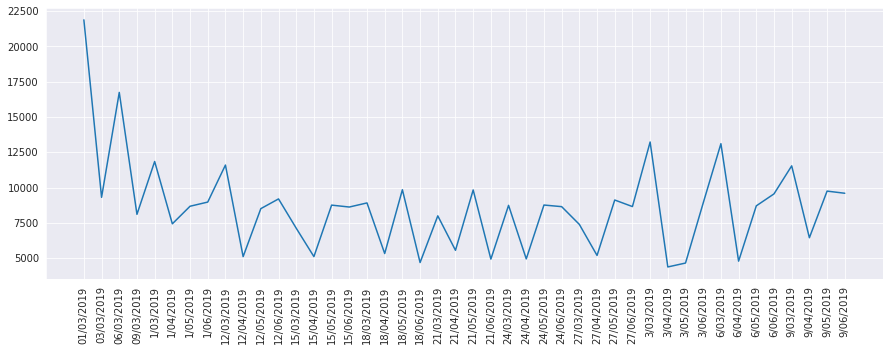

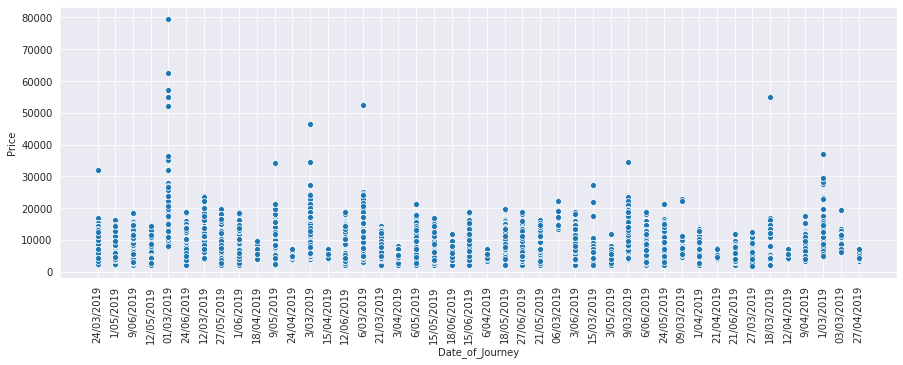

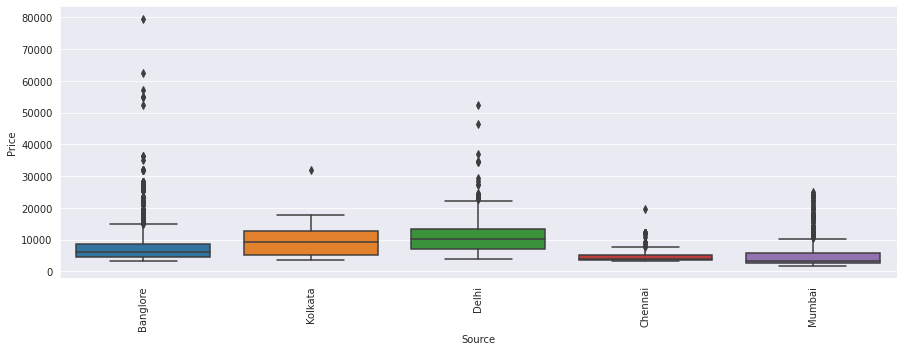

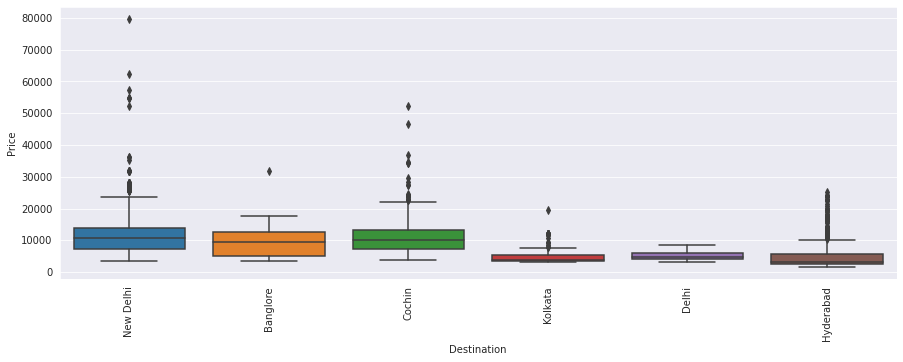

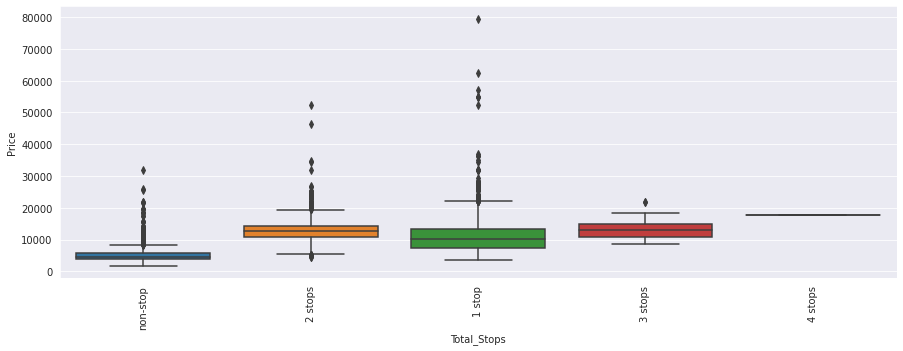

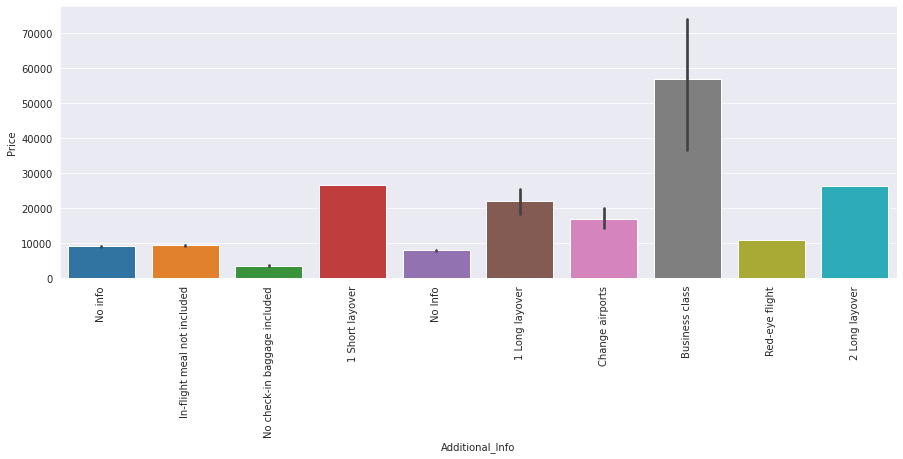

In [11]:
# price by "Airline"
plt.subplots(figsize=(15,5))
plt.xticks(rotation=90)
sns.boxplot(train_data.loc[:,'Airline'], train_data.loc[:,'Price'])

# check how "Price" varied, on average, by each "Date_of_Journey"
plt.subplots(figsize=(15,5))
plt.xticks(rotation=90)
plt.plot(train_data.sort_values(by='Date_of_Journey').loc[:,'Date_of_Journey'].unique(), train_data.groupby(by='Date_of_Journey')['Price'].mean())

# seeing how price was, by all dates
plt.subplots(figsize=(15,5))
plt.xticks(rotation=90)
sns.scatterplot(train_data.loc[:,'Date_of_Journey'], train_data.loc[:,'Price'])

plt.subplots(figsize=(15,5))
plt.xticks(rotation=90)
sns.boxplot(train_data.loc[:,'Source'], train_data.loc[:,'Price'])

plt.subplots(figsize=(15,5))
plt.xticks(rotation=90)
sns.boxplot(train_data.loc[:,'Destination'], train_data.loc[:,'Price'])

plt.subplots(figsize=(15,5))
plt.xticks(rotation=90)
sns.boxplot(train_data.loc[:,'Total_Stops'], train_data.loc[:,'Price'])

plt.subplots(figsize=(15,5))
plt.xticks(rotation=90)
sns.barplot(train_data.loc[:,'Additional_Info'], train_data.loc[:,'Price'])

## Data Cleaning & Feature Engineering

In [12]:
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [13]:
train_data.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')

In [14]:
train_data

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648


In [15]:
test_data = pd.read_excel('Test_set.xlsx')
test_data.loc[:,'Price'] = 0
test_data

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info,0
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info,0
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included,0
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info,0
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info,0
...,...,...,...,...,...,...,...,...,...,...,...
2666,Air India,6/06/2019,Kolkata,Banglore,CCU → DEL → BLR,20:30,20:25 07 Jun,23h 55m,1 stop,No info,0
2667,IndiGo,27/03/2019,Kolkata,Banglore,CCU → BLR,14:20,16:55,2h 35m,non-stop,No info,0
2668,Jet Airways,6/03/2019,Delhi,Cochin,DEL → BOM → COK,21:50,04:25 07 Mar,6h 35m,1 stop,No info,0
2669,Air India,6/03/2019,Delhi,Cochin,DEL → BOM → COK,04:00,19:15,15h 15m,1 stop,No info,0


In [16]:
full_data = pd.concat([train_data, test_data], ignore_index=True)

In [17]:
train_data.shape, test_data.shape, full_data.shape

((10683, 11), (2671, 11), (13354, 11))

In [18]:
full_data.loc[:10_682,:]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648


In [19]:
full_data.loc[10_683:,:]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
10683,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info,0
10684,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info,0
10685,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included,0
10686,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info,0
10687,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info,0
...,...,...,...,...,...,...,...,...,...,...,...
13349,Air India,6/06/2019,Kolkata,Banglore,CCU → DEL → BLR,20:30,20:25 07 Jun,23h 55m,1 stop,No info,0
13350,IndiGo,27/03/2019,Kolkata,Banglore,CCU → BLR,14:20,16:55,2h 35m,non-stop,No info,0
13351,Jet Airways,6/03/2019,Delhi,Cochin,DEL → BOM → COK,21:50,04:25 07 Mar,6h 35m,1 stop,No info,0
13352,Air India,6/03/2019,Delhi,Cochin,DEL → BOM → COK,04:00,19:15,15h 15m,1 stop,No info,0


In [20]:
full_data.loc[:10_682,:].shape, full_data.loc[10_683:,:].shape, full_data.shape

((10683, 11), (2671, 11), (13354, 11))

In [21]:
10_683 + 2_671

13354

In [22]:
del train_data, test_data

#### `Arrival_Time` column

In [23]:
pd.set_option('display.max_rows', 2_000)
full_data.loc[:,'Arrival_Time'].value_counts()

19:00           536
21:00           466
19:15           434
16:10           185
12:35           159
20:45           141
18:50           138
22:30           136
22:50           134
11:20           112
19:50           112
21:20           109
12:20           100
22:25            97
20:05            90
21:05            86
08:35            85
23:35            84
14:05            83
12:00            81
19:45            76
08:45            73
07:15            73
22:35            71
23:00            71
12:55            70
18:10            68
19:40            66
11:25            65
10:10            65
13:15            65
15:30            65
10:40            64
19:35            63
22:20            63
21:50            63
12:10            62
07:45            62
16:20            62
04:25 07 Jun     61
22:55            61
13:55            61
22:00            60
11:50            60
10:05            59
09:30            59
23:15            58
22:15            58
08:50            57
18:25            57


In [24]:
# let's only extract the time
len("19:10 ")

6

In [25]:
full_data.loc[:,'Arrival_Time'] = full_data.loc[:,'Arrival_Time'].str.slice(0,6)
full_data.loc[:10, 'Arrival_Time']

0     01:10 
1      13:15
2     04:25 
3      23:30
4      21:35
5      11:25
6     10:25 
7     05:05 
8     10:25 
9      19:15
10     23:00
Name: Arrival_Time, dtype: object

In [26]:
full_data.loc[:,'Arrival_Time'] = full_data.loc[:,'Arrival_Time'].str.strip()
full_data.loc[:,'Arrival_Time']

0        01:10
1        13:15
2        04:25
3        23:30
4        21:35
         ...  
13349    20:25
13350    16:55
13351    04:25
13352    19:15
13353    19:15
Name: Arrival_Time, Length: 13354, dtype: object

In [27]:
full_data.loc[:,'Arrival_Time'] = pd.to_datetime(full_data.loc[:,'Arrival_Time'], format="%H:%M").dt.time
full_data.loc[:,'Arrival_Time']

0        01:10:00
1        13:15:00
2        04:25:00
3        23:30:00
4        21:35:00
           ...   
13349    20:25:00
13350    16:55:00
13351    04:25:00
13352    19:15:00
13353    19:15:00
Name: Arrival_Time, Length: 13354, dtype: object

In [28]:
full_data.shape

(13354, 11)

#### `Date_of_Journey` column

In [29]:
full_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10:00,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15:00,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25:00,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30:00,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35:00,4h 45m,1 stop,No info,13302


In [30]:
full_data.loc[:,"Date_of_Journey"] = pd.to_datetime(full_data.loc[:,"Date_of_Journey"], format='%d/%m/%Y').dt.date
full_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10:00,2h 50m,non-stop,No info,3897
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15:00,7h 25m,2 stops,No info,7662
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25:00,19h,2 stops,No info,13882
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30:00,5h 25m,1 stop,No info,6218
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35:00,4h 45m,1 stop,No info,13302


In [31]:
full_data.shape

(13354, 11)

#### `Duration` column

In [32]:
full_data.loc[:10,'Duration'].str.slice(0,2).str.extract(r'(\d+)').astype('int')

,0
0,2
1,7
2,19
3,5
4,4
5,2
6,15
7,21
8,25
9,7


In [33]:
# Converting duration from string to integer value in minutes
# slicing from 3rd index will only give minutes
minutes = full_data.loc[:,'Duration'].str.slice(3,).str.extract(r'(\d+)')
# fill with 0, for the times, that doesn't have minutes
minutes.fillna(value=0, inplace=True)
# extract hours now
hours = full_data.loc[:,'Duration'].str.slice(0,2).str.extract(r'(\d+)')
hours.fillna(value=0, inplace=True)

In [34]:
hours.head()

,0
0,2
1,7
2,19
3,5
4,4


In [35]:
minutes.head()

,0
0,50
1,25
2,0
3,25
4,45


In [36]:
# let's convert them both to pd.Series
minutes = pd.Series(minutes.iloc[:,0])
hours = pd.Series(hours.iloc[:,0])

In [37]:
hours[0], minutes[0]

('2', '50')

In [38]:
minutes.astype(np.int64) + (hours.astype(np.float64) * 60)

0         170.0
1         445.0
2        1140.0
3         325.0
4         285.0
          ...  
13349    1435.0
13350     155.0
13351     395.0
13352     915.0
13353     860.0
Name: 0, Length: 13354, dtype: float64

In [39]:
full_data.loc[:,'Duration'] = minutes.astype(np.int64) + (hours.astype(np.float64) * 60)
full_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10:00,170.0,non-stop,No info,3897
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15:00,445.0,2 stops,No info,7662
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25:00,1140.0,2 stops,No info,13882
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30:00,325.0,1 stop,No info,6218
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35:00,285.0,1 stop,No info,13302


#### let's make a new column called `Date_of_Arrival` adding `Date_of_Journey` and `Duration` columns

In [40]:
# Since 'Duration' column is total minutes, let's convert it to hours, so it can be added(sum) with 'Date_of_Journey' column
pd.to_timedelta(full_data.loc[:,'Duration'],unit='m')

0       02:50:00
1       07:25:00
2       19:00:00
3       05:25:00
4       04:45:00
          ...   
13349   23:55:00
13350   02:35:00
13351   06:35:00
13352   15:15:00
13353   14:20:00
Name: Duration, Length: 13354, dtype: timedelta64[ns]

In [41]:
pd.to_datetime(full_data.loc[:, 'Date_of_Journey'].astype(str) + ' ' + full_data.loc[:, 'Dep_Time'])

0       2019-03-24 22:20:00
1       2019-05-01 05:50:00
2       2019-06-09 09:25:00
3       2019-05-12 18:05:00
4       2019-03-01 16:50:00
                ...        
13349   2019-06-06 20:30:00
13350   2019-03-27 14:20:00
13351   2019-03-06 21:50:00
13352   2019-03-06 04:00:00
13353   2019-06-15 04:55:00
Length: 13354, dtype: datetime64[ns]

In [42]:
pd.to_datetime(full_data.loc[:, 'Date_of_Journey'].astype(str) + ' ' + full_data.loc[:, 'Dep_Time']) + pd.to_timedelta(full_data.loc[:,'Duration'],unit='m')

0       2019-03-25 01:10:00
1       2019-05-01 13:15:00
2       2019-06-10 04:25:00
3       2019-05-12 23:30:00
4       2019-03-01 21:35:00
                ...        
13349   2019-06-07 20:25:00
13350   2019-03-27 16:55:00
13351   2019-03-07 04:25:00
13352   2019-03-06 19:15:00
13353   2019-06-15 19:15:00
Length: 13354, dtype: datetime64[ns]

In [43]:
full_data.loc[:,'Date_of_Arrival'] = pd.to_datetime(full_data.loc[:, 'Date_of_Journey'].astype(str) + ' ' + full_data.loc[:, 'Dep_Time']) + pd.to_timedelta(full_data.loc[:,'Duration'],unit='m')
full_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date_of_Arrival
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10:00,170.0,non-stop,No info,3897,2019-03-25 01:10:00
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15:00,445.0,2 stops,No info,7662,2019-05-01 13:15:00
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25:00,1140.0,2 stops,No info,13882,2019-06-10 04:25:00
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30:00,325.0,1 stop,No info,6218,2019-05-12 23:30:00
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35:00,285.0,1 stop,No info,13302,2019-03-01 21:35:00


In [44]:
full_data.loc[:,'Date_of_Arrival'] = pd.to_datetime(full_data.loc[:,'Date_of_Arrival']).dt.date
full_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date_of_Arrival
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10:00,170.0,non-stop,No info,3897,2019-03-25
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15:00,445.0,2 stops,No info,7662,2019-05-01
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25:00,1140.0,2 stops,No info,13882,2019-06-10
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30:00,325.0,1 stop,No info,6218,2019-05-12
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35:00,285.0,1 stop,No info,13302,2019-03-01


In [45]:
full_data.shape

(13354, 12)

#### `Total_Stops` column

In [46]:
full_data.loc[:,'Total_Stops'].value_counts()

1 stop      7056
non-stop    4340
2 stops     1899
3 stops       56
4 stops        2
Name: Total_Stops, dtype: int64

In [47]:
# extract the digit that corresponds to number of stops; and since findall returns lists, extract first element;
# and also, as can be seen above, there is no '0' for 0 stops, but non-stop, hence nulls have to be filled with '0'. and then covert this column to category
# full_data.loc[:,'Total_Stops'] = full_data.loc[:,'Total_Stops'].str.findall(r'(\d)').str.get(0).astype('category')
# full_data.loc[:,'Total_Stops'] = full_data.loc[:,'Total_Stops'].str.findall(r'(\d)').str.get(0).fillna(0).astype('category')
total_stops_dict = {'non-stop':0,'2 stops':2,'1 stop':1,'3 stops':3,'4 stops': 4}
full_data.loc[:,'Total_Stops']=full_data.loc[:,'Total_Stops'].map(total_stops_dict)
full_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date_of_Arrival
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10:00,170.0,0.0,No info,3897,2019-03-25
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15:00,445.0,2.0,No info,7662,2019-05-01
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25:00,1140.0,2.0,No info,13882,2019-06-10
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30:00,325.0,1.0,No info,6218,2019-05-12
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35:00,285.0,1.0,No info,13302,2019-03-01


In [48]:
full_data.shape

(13354, 12)

#### making a new column called `Class` from Airline

In [49]:
full_data.loc[:,'Airline'].value_counts()

Jet Airways                          4746
IndiGo                               2564
Air India                            2192
Multiple carriers                    1543
SpiceJet                             1026
Vistara                               608
Air Asia                              405
GoAir                                 240
Multiple carriers Premium economy      16
Jet Airways Business                    8
Vistara Premium economy                 5
Trujet                                  1
Name: Airline, dtype: int64

since end of the string, for some columns, already has class information, let's use 'Economy' for the ones that doesn't.

In [50]:
# let's extract class that's present, in second position of the list, whe split by space
class_variable = full_data.loc[:,'Airline'].str.split(' ', expand=True).get(2)
class_variable.value_counts()

Premium     16
Business     8
economy      5
Name: 2, dtype: int64

In [51]:
class_dict = {'Premium':'Premium Economy', 'economy': 'Premium Economy', 'Business':'Business', None:'Economy'}
class_variable = class_variable.map(class_dict)
class_variable.value_counts()

Economy            13325
Premium Economy       21
Business               8
Name: 2, dtype: int64

In [52]:
full_data.loc[:,'Class'] = class_variable
full_data.loc[:,'Class'] = full_data.loc[:,'Class'].astype('category')
full_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date_of_Arrival,Class
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10:00,170.0,0.0,No info,3897,2019-03-25,Economy
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15:00,445.0,2.0,No info,7662,2019-05-01,Economy
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25:00,1140.0,2.0,No info,13882,2019-06-10,Economy
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30:00,325.0,1.0,No info,6218,2019-05-12,Economy
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35:00,285.0,1.0,No info,13302,2019-03-01,Economy


In [53]:
full_data.loc[:,'Class'].value_counts()

Economy            13325
Premium Economy       21
Business               8
Name: Class, dtype: int64

In [54]:
full_data.shape

(13354, 13)

#### `Additional_Info` column

In [55]:
full_data.loc[:,'Additional_Info'].value_counts()

No info                         10493
In-flight meal not included      2426
No check-in baggage included      396
1 Long layover                     20
Change airports                     8
Business class                      5
No Info                             3
Red-eye flight                      1
2 Long layover                      1
1 Short layover                     1
Name: Additional_Info, dtype: int64

In [56]:
# The column Additional info had values No info and No Info stored, editing to bring them to the same string value
full_data.loc[full_data.loc[:,'Additional_Info'] == "No info",'Additional_Info'] = "No Info"
full_data.loc[:,'Additional_Info'].value_counts()

No Info                         10496
In-flight meal not included      2426
No check-in baggage included      396
1 Long layover                     20
Change airports                     8
Business class                      5
Red-eye flight                      1
2 Long layover                      1
1 Short layover                     1
Name: Additional_Info, dtype: int64

In [57]:
full_data.shape

(13354, 13)

#### making a new column `Same_day_travel`

In [58]:
full_data.loc[0,'Date_of_Arrival'] - full_data.loc[0,'Date_of_Journey']

datetime.timedelta(1)

In [59]:
full_data.loc[:,'Same_day_travel'] = full_data.loc[:,'Date_of_Arrival'] - full_data.loc[:,'Date_of_Journey']
full_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date_of_Arrival,Class,Same_day_travel
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10:00,170.0,0.0,No Info,3897,2019-03-25,Economy,1 days
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15:00,445.0,2.0,No Info,7662,2019-05-01,Economy,0 days
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25:00,1140.0,2.0,No Info,13882,2019-06-10,Economy,1 days
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30:00,325.0,1.0,No Info,6218,2019-05-12,Economy,0 days
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35:00,285.0,1.0,No Info,13302,2019-03-01,Economy,0 days


In [60]:
full_data.loc[:,'Same_day_travel'].value_counts()

0 days    7951
1 days    5340
2 days      63
Name: Same_day_travel, dtype: int64

In [61]:
# full_data.loc[:,'Same_day_travel'] = 
# full_data.loc[:,'Same_day_travel'].astype(str).str.findall(r'(\d)').str.get(0).astype(int).value_counts()
# full_data.loc[:,'Same_day_travel']

In [62]:
full_data.loc[:,'Same_day_travel'] = full_data.loc[:,'Same_day_travel'].astype('category')

In [63]:
full_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date_of_Arrival,Class,Same_day_travel
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10:00,170.0,0.0,No Info,3897,2019-03-25,Economy,1 days
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15:00,445.0,2.0,No Info,7662,2019-05-01,Economy,0 days
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25:00,1140.0,2.0,No Info,13882,2019-06-10,Economy,1 days
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30:00,325.0,1.0,No Info,6218,2019-05-12,Economy,0 days
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35:00,285.0,1.0,No Info,13302,2019-03-01,Economy,0 days


In [64]:
full_data.dtypes

Airline              object
Date_of_Journey      object
Source               object
Destination          object
Route                object
Dep_Time             object
Arrival_Time         object
Duration            float64
Total_Stops         float64
Additional_Info      object
Price                 int64
Date_of_Arrival      object
Class              category
Same_day_travel    category
dtype: object

In [65]:
full_data.loc[:,'Airline'] = full_data.loc[:,'Airline'].astype('category')
full_data.dtypes

Airline            category
Date_of_Journey      object
Source               object
Destination          object
Route                object
Dep_Time             object
Arrival_Time         object
Duration            float64
Total_Stops         float64
Additional_Info      object
Price                 int64
Date_of_Arrival      object
Class              category
Same_day_travel    category
dtype: object

In [66]:
full_data.shape

(13354, 14)

#### creating 2 columns for indicating "weekday" travel

In [67]:
pd.to_datetime(full_data.loc[:10,'Date_of_Journey']).dt.weekday

0     6
1     2
2     6
3     6
4     4
5     0
6     1
7     4
8     1
9     0
10    5
Name: Date_of_Journey, dtype: int64

In [68]:
full_data.loc[:10,'Date_of_Journey'].apply(lambda x:x.weekday())

0     6
1     2
2     6
3     6
4     4
5     0
6     1
7     4
8     1
9     0
10    5
Name: Date_of_Journey, dtype: int64

In [69]:
# this highlight the fact that what day of the week the flight took off and and arrived.
# the idea is that the flight ticket prices will be marginally higher on weekends and these columns can help catch that.
full_data.loc[:,'weekday_journey'] = full_data.loc[:,'Date_of_Journey'].apply(lambda x:x.weekday())
full_data.loc[:,'weekday_arrival'] = full_data.loc[:,'Date_of_Arrival'].apply(lambda x:x.weekday())
full_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date_of_Arrival,Class,Same_day_travel,weekday_journey,weekday_arrival
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10:00,170.0,0.0,No Info,3897,2019-03-25,Economy,1 days,6,0
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15:00,445.0,2.0,No Info,7662,2019-05-01,Economy,0 days,2,2
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25:00,1140.0,2.0,No Info,13882,2019-06-10,Economy,1 days,6,0
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30:00,325.0,1.0,No Info,6218,2019-05-12,Economy,0 days,6,6
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35:00,285.0,1.0,No Info,13302,2019-03-01,Economy,0 days,4,4


In [70]:
full_data.shape

(13354, 16)

#### creating "year", "month" and "date" columns to capture seasonality

In [71]:
full_data.loc[:,'Year_of_Journey'] = pd.to_datetime(full_data.loc[:,'Date_of_Journey']).dt.year
full_data.loc[:,'month_of_Journey'] = pd.to_datetime(full_data.loc[:,'Date_of_Journey']).dt.month
full_data.loc[:,'day_of_Journey'] = pd.to_datetime(full_data.loc[:,'Date_of_Journey']).dt.day
full_data.loc[:,'Year_of_Arrival'] = pd.to_datetime(full_data.loc[:,'Date_of_Arrival']).dt.year
full_data.loc[:,'month_of_Arrival'] = pd.to_datetime(full_data.loc[:,'Date_of_Arrival']).dt.month
full_data.loc[:,'day_of_Arrival'] = pd.to_datetime(full_data.loc[:,'Date_of_Arrival']).dt.day
full_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date_of_Arrival,Class,Same_day_travel,weekday_journey,weekday_arrival,Year_of_Journey,month_of_Journey,day_of_Journey,Year_of_Arrival,month_of_Arrival,day_of_Arrival
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10:00,170.0,0.0,No Info,3897,2019-03-25,Economy,1 days,6,0,2019,3,24,2019,3,25
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15:00,445.0,2.0,No Info,7662,2019-05-01,Economy,0 days,2,2,2019,5,1,2019,5,1
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25:00,1140.0,2.0,No Info,13882,2019-06-10,Economy,1 days,6,0,2019,6,9,2019,6,10
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30:00,325.0,1.0,No Info,6218,2019-05-12,Economy,0 days,6,6,2019,5,12,2019,5,12
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35:00,285.0,1.0,No Info,13302,2019-03-01,Economy,0 days,4,4,2019,3,1,2019,3,1


In [72]:
(full_data.loc[:,'Year_of_Arrival'] == full_data.loc[:,'Year_of_Journey']).value_counts()

True    13354
dtype: int64

In [73]:
full_data.drop(columns=['Year_of_Arrival'], axis=1, inplace=True)
full_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date_of_Arrival,Class,Same_day_travel,weekday_journey,weekday_arrival,Year_of_Journey,month_of_Journey,day_of_Journey,month_of_Arrival,day_of_Arrival
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10:00,170.0,0.0,No Info,3897,2019-03-25,Economy,1 days,6,0,2019,3,24,3,25
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15:00,445.0,2.0,No Info,7662,2019-05-01,Economy,0 days,2,2,2019,5,1,5,1
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25:00,1140.0,2.0,No Info,13882,2019-06-10,Economy,1 days,6,0,2019,6,9,6,10
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30:00,325.0,1.0,No Info,6218,2019-05-12,Economy,0 days,6,6,2019,5,12,5,12
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35:00,285.0,1.0,No Info,13302,2019-03-01,Economy,0 days,4,4,2019,3,1,3,1


In [74]:
(full_data.loc[:,'month_of_Arrival'] == full_data.loc[:,'month_of_Journey']).value_counts()

True    13354
dtype: int64

In [75]:
full_data.drop(columns=['month_of_Arrival'], axis=1, inplace=True)
full_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date_of_Arrival,Class,Same_day_travel,weekday_journey,weekday_arrival,Year_of_Journey,month_of_Journey,day_of_Journey,day_of_Arrival
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10:00,170.0,0.0,No Info,3897,2019-03-25,Economy,1 days,6,0,2019,3,24,25
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15:00,445.0,2.0,No Info,7662,2019-05-01,Economy,0 days,2,2,2019,5,1,1
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25:00,1140.0,2.0,No Info,13882,2019-06-10,Economy,1 days,6,0,2019,6,9,10
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30:00,325.0,1.0,No Info,6218,2019-05-12,Economy,0 days,6,6,2019,5,12,12
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35:00,285.0,1.0,No Info,13302,2019-03-01,Economy,0 days,4,4,2019,3,1,1


In [76]:
(full_data.loc[:,'day_of_Arrival'] == full_data.loc[:,'day_of_Journey']).value_counts()

True     7951
False    5403
dtype: int64

In [77]:
full_data.shape

(13354, 20)

#### creating two columns to indicate number of landings and take-offs on a date

In [78]:
temp_group = pd.DataFrame(full_data.groupby(by=['Date_of_Journey']).size(), columns=['num_takeoffs_on_date']).reset_index()
temp_group 

,Date_of_Journey,num_takeoffs_on_date
0,2019-03-01,245
1,2019-03-03,403
2,2019-03-06,528
3,2019-03-09,378
4,2019-03-12,185
5,2019-03-15,195
6,2019-03-18,197
7,2019-03-21,516
8,2019-03-24,401
9,2019-03-27,364


In [79]:
full_data = full_data.merge(temp_group, on=['Date_of_Journey'], how='left')
full_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date_of_Arrival,Class,Same_day_travel,weekday_journey,weekday_arrival,Year_of_Journey,month_of_Journey,day_of_Journey,day_of_Arrival,num_takeoffs_on_date
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10:00,170.0,0.0,No Info,3897,2019-03-25,Economy,1 days,6,0,2019,3,24,25,401
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15:00,445.0,2.0,No Info,7662,2019-05-01,Economy,0 days,2,2,2019,5,1,1,339
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25:00,1140.0,2.0,No Info,13882,2019-06-10,Economy,1 days,6,0,2019,6,9,10,614
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30:00,325.0,1.0,No Info,6218,2019-05-12,Economy,0 days,6,6,2019,5,12,12,327
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35:00,285.0,1.0,No Info,13302,2019-03-01,Economy,0 days,4,4,2019,3,1,1,245


In [80]:
del temp_group
temp_group = pd.DataFrame(full_data.groupby(by=['Date_of_Arrival']).size(), columns=['num_landings_on_date']).reset_index()
full_data = full_data.merge(temp_group, on=['Date_of_Arrival'], how='left')
full_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date_of_Arrival,Class,Same_day_travel,weekday_journey,weekday_arrival,Year_of_Journey,month_of_Journey,day_of_Journey,day_of_Arrival,num_takeoffs_on_date,num_landings_on_date
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10:00,170.0,0.0,No Info,3897,2019-03-25,Economy,1 days,6,0,2019,3,24,25,401,163
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15:00,445.0,2.0,No Info,7662,2019-05-01,Economy,0 days,2,2,2019,5,1,1,339,189
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25:00,1140.0,2.0,No Info,13882,2019-06-10,Economy,1 days,6,0,2019,6,9,10,614,302
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30:00,325.0,1.0,No Info,6218,2019-05-12,Economy,0 days,6,6,2019,5,12,12,327,181
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35:00,285.0,1.0,No Info,13302,2019-03-01,Economy,0 days,4,4,2019,3,1,1,245,151


In [81]:
pd.DataFrame(full_data.groupby(by=['Date_of_Journey', 'Source']).size(), columns=['num_takeoff_source']).reset_index()

,Date_of_Journey,Source,num_takeoff_source
0,2019-03-01,Banglore,186
1,2019-03-01,Chennai,12
2,2019-03-01,Delhi,10
3,2019-03-01,Kolkata,18
4,2019-03-01,Mumbai,19
5,2019-03-03,Banglore,123
6,2019-03-03,Chennai,12
7,2019-03-03,Delhi,228
8,2019-03-03,Kolkata,19
9,2019-03-03,Mumbai,21


In [82]:
temp_group = pd.DataFrame(full_data.groupby(by=['Date_of_Journey', 'Source']).size(), columns=['num_takeoff_source']).reset_index()
full_data = full_data.merge(temp_group, how='left', on=['Date_of_Journey', 'Source'])
full_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date_of_Arrival,Class,Same_day_travel,weekday_journey,weekday_arrival,Year_of_Journey,month_of_Journey,day_of_Journey,day_of_Arrival,num_takeoffs_on_date,num_landings_on_date,num_takeoff_source
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10:00,170.0,0.0,No Info,3897,2019-03-25,Economy,1 days,6,0,2019,3,24,25,401,163,123
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15:00,445.0,2.0,No Info,7662,2019-05-01,Economy,0 days,2,2,2019,5,1,1,339,189,226
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25:00,1140.0,2.0,No Info,13882,2019-06-10,Economy,1 days,6,0,2019,6,9,10,614,302,291
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30:00,325.0,1.0,No Info,6218,2019-05-12,Economy,0 days,6,6,2019,5,12,12,327,181,222
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35:00,285.0,1.0,No Info,13302,2019-03-01,Economy,0 days,4,4,2019,3,1,1,245,151,186


In [83]:
del temp_group
temp_group = pd.DataFrame(full_data.groupby(by=['Date_of_Arrival', 'Source']).size(), columns=['num_landing_destination']).reset_index()
full_data = full_data.merge(temp_group, how='left', on=['Date_of_Arrival', 'Source'])
full_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date_of_Arrival,Class,Same_day_travel,weekday_journey,weekday_arrival,Year_of_Journey,month_of_Journey,day_of_Journey,day_of_Arrival,num_takeoffs_on_date,num_landings_on_date,num_takeoff_source,num_landing_destination
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10:00,170.0,0.0,No Info,3897,2019-03-25,Economy,1 days,6,0,2019,3,24,25,401,163,123,19
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15:00,445.0,2.0,No Info,7662,2019-05-01,Economy,0 days,2,2,2019,5,1,1,339,189,226,96
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25:00,1140.0,2.0,No Info,13882,2019-06-10,Economy,1 days,6,0,2019,6,9,10,614,302,291,160
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30:00,325.0,1.0,No Info,6218,2019-05-12,Economy,0 days,6,6,2019,5,12,12,327,181,222,86
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35:00,285.0,1.0,No Info,13302,2019-03-01,Economy,0 days,4,4,2019,3,1,1,245,151,186,103


In [84]:
full_data.shape

(13354, 24)

## target variable normalisation

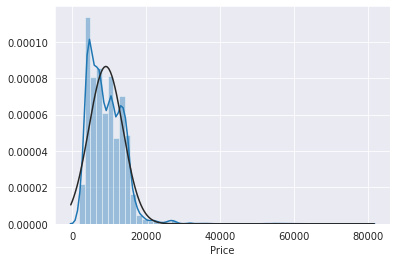

((array([-3.82690953, -3.60266143, -3.4795895 , ...,  3.4795895 ,
          3.60266143,  3.82690953]),
  array([ 1759,  1759,  1759, ..., 57209, 62427, 79512])),
 (4364.062692425855, 9087.064120565383, 0.9460976378917301))

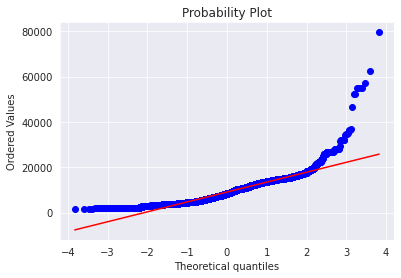

In [85]:
sns.distplot(full_data.loc[full_data.loc[:,'Price'] != 0].loc[:,'Price'], fit=stats.norm)
l=plt.show()
stats.probplot(full_data.loc[full_data.loc[:,'Price'] != 0].loc[:,'Price'],plot=plt)

let's take log of it and check the fit

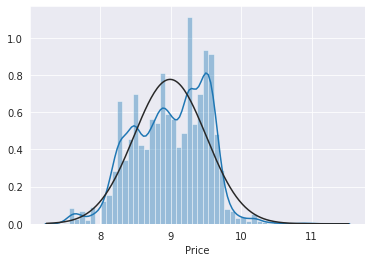

((array([-3.82690953, -3.60266143, -3.4795895 , ...,  3.4795895 ,
          3.60266143,  3.82690953]),
  array([ 7.47250074,  7.47250074,  7.47250074, ..., 10.95446651,
         11.04175315, 11.28366323])),
 (0.50810528924744, 8.989144534386861, 0.988996119401397))

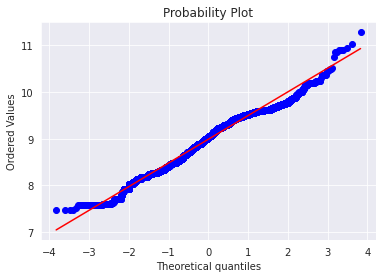

In [86]:
xt = np.log(full_data.loc[:10_682,'Price'])
sns.distplot(xt, fit=stats.norm)
l=plt.show()
stats.probplot(xt, plot=plt)

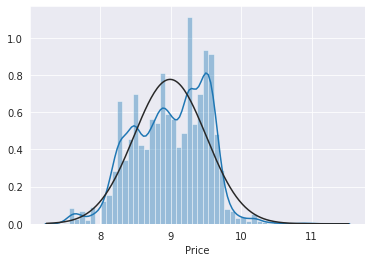

In [87]:
# since 'np.log' seemed to be normal, let's use it
full_data.loc[:10_682,'Price'] = np.log(full_data.loc[:10_682,'Price'])
sns.distplot(full_data.loc[:10_682,'Price'] , fit=stats.norm)

## null value treatment

In [88]:
full_data.isnull().sum()

Airline                    0
Date_of_Journey            0
Source                     0
Destination                0
Route                      1
Dep_Time                   0
Arrival_Time               0
Duration                   0
Total_Stops                1
Additional_Info            0
Price                      0
Date_of_Arrival            0
Class                      0
Same_day_travel            0
weekday_journey            0
weekday_arrival            0
Year_of_Journey            0
month_of_Journey           0
day_of_Journey             0
day_of_Arrival             0
num_takeoffs_on_date       0
num_landings_on_date       0
num_takeoff_source         0
num_landing_destination    0
dtype: int64

In [89]:
full_data.loc[full_data.isnull().any(axis=1)]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date_of_Arrival,Class,Same_day_travel,weekday_journey,weekday_arrival,Year_of_Journey,month_of_Journey,day_of_Journey,day_of_Arrival,num_takeoffs_on_date,num_landings_on_date,num_takeoff_source,num_landing_destination
9039,Air India,2019-05-06,Delhi,Cochin,NaN,09:45,09:25:00,1420.0,NaN,No Info,8.919988,2019-05-07,Economy,1 days,0,1,2019,5,6,7,355,161,32,19


In [90]:
# let's find out rows that has similar values in columns and use them for imputation
impute_df = full_data.loc[(pd.DatetimeIndex(full_data.loc[:,'Date_of_Journey']).month==5) &
                           (full_data.loc[:,'Source'] == 'Delhi') &
                           (full_data.loc[:,'Destination'] == 'Cochin') &
                           (full_data.loc[:,'Duration'] == 1420) & 
                           (full_data.loc[:,'Airline'] == 'Air India')].sort_values(by='Date_of_Journey')
impute_df

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date_of_Arrival,Class,Same_day_travel,weekday_journey,weekday_arrival,Year_of_Journey,month_of_Journey,day_of_Journey,day_of_Arrival,num_takeoffs_on_date,num_landings_on_date,num_takeoff_source,num_landing_destination
9039,Air India,2019-05-06,Delhi,Cochin,NaN,09:45,09:25:00,1420.0,NaN,No Info,8.919988,2019-05-07,Economy,1 days,0,1,2019,5,6,7,355,161,32,19
10348,Air India,2019-05-09,Delhi,Cochin,DEL → HYD → MAA → COK,09:45,09:25:00,1420.0,2.0,No Info,9.202812,2019-05-10,Economy,1 days,3,4,2019,5,9,10,628,289,304,148
12318,Air India,2019-05-09,Delhi,Cochin,DEL → MAA → COK,09:45,09:25:00,1420.0,1.0,No Info,0.000000,2019-05-10,Economy,1 days,3,4,2019,5,9,10,628,289,304,148
2343,Air India,2019-05-15,Delhi,Cochin,DEL → HYD → MAA → COK,09:45,09:25:00,1420.0,2.0,No Info,9.303375,2019-05-16,Economy,1 days,2,3,2019,5,15,16,511,206,192,71
2554,Air India,2019-05-15,Delhi,Cochin,DEL → MAA → COK,09:45,09:25:00,1420.0,1.0,No Info,8.919988,2019-05-16,Economy,1 days,2,3,2019,5,15,16,511,206,192,71
3595,Air India,2019-05-18,Delhi,Cochin,DEL → MAA → COK,09:45,09:25:00,1420.0,1.0,No Info,9.032648,2019-05-19,Economy,1 days,5,6,2019,5,18,19,633,292,310,155
9717,Air India,2019-05-18,Delhi,Cochin,DEL → HYD → MAA → COK,09:45,09:25:00,1420.0,2.0,No Info,9.303375,2019-05-19,Economy,1 days,5,6,2019,5,18,19,633,292,310,155
8135,Air India,2019-05-21,Delhi,Cochin,DEL → HYD → MAA → COK,09:45,09:25:00,1420.0,2.0,No Info,9.303375,2019-05-22,Economy,1 days,1,2,2019,5,21,22,615,294,300,156
1616,Air India,2019-05-24,Delhi,Cochin,DEL → MAA → COK,09:45,09:25:00,1420.0,1.0,No Info,8.919988,2019-05-25,Economy,1 days,4,5,2019,5,24,25,357,164,33,16


In [91]:
# let's check the most occured values in the columns we have nulls in
impute_df.loc[:,'Route'].value_counts()

DEL → HYD → MAA → COK    4
DEL → MAA → COK          4
Name: Route, dtype: int64

In [92]:
full_data.loc[:,'Route'].isnull().sum()

1

In [93]:
full_data.loc[:,'Route'] = full_data.loc[:,'Route'].fillna('DEL → MAA → COK')
full_data.loc[:,'Route'].isnull().sum()

0

In [94]:
full_data.loc[:,'Total_Stops'].isnull().sum()

1

In [95]:
full_data.loc[:,'Total_Stops'] = full_data.loc[:,'Total_Stops'].fillna('1')
full_data.loc[:,'Total_Stops'].isnull().sum()

0

In [96]:
full_data.loc[:,"Total_Stops"].value_counts()

1.0    7056
0.0    4340
2.0    1899
3.0      56
4.0       2
1         1
Name: Total_Stops, dtype: int64

In [97]:
full_data.loc[:,'Total_Stops'] = full_data.loc[:,'Total_Stops'].astype(np.int64)
full_data.loc[:,"Total_Stops"].value_counts()

1    7057
0    4340
2    1899
3      56
4       2
Name: Total_Stops, dtype: int64

# Skew Treatment

In [98]:
full_data.dtypes

Airline                    category
Date_of_Journey              object
Source                       object
Destination                  object
Route                        object
Dep_Time                     object
Arrival_Time                 object
Duration                    float64
Total_Stops                   int64
Additional_Info              object
Price                       float64
Date_of_Arrival              object
Class                      category
Same_day_travel            category
weekday_journey               int64
weekday_arrival               int64
Year_of_Journey               int64
month_of_Journey              int64
day_of_Journey                int64
day_of_Arrival                int64
num_takeoffs_on_date          int64
num_landings_on_date          int64
num_takeoff_source            int64
num_landing_destination       int64
dtype: object

In [99]:
full_data

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date_of_Arrival,Class,Same_day_travel,weekday_journey,weekday_arrival,Year_of_Journey,month_of_Journey,day_of_Journey,day_of_Arrival,num_takeoffs_on_date,num_landings_on_date,num_takeoff_source,num_landing_destination
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10:00,170.0,0,No Info,8.267962,2019-03-25,Economy,1 days,6,0,2019,3,24,25,401,163,123,19
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15:00,445.0,2,No Info,8.944028,2019-05-01,Economy,0 days,2,2,2019,5,1,1,339,189,226,96
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25:00,1140.0,2,No Info,9.538348,2019-06-10,Economy,1 days,6,0,2019,6,9,10,614,302,291,160
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30:00,325.0,1,No Info,8.735204,2019-05-12,Economy,0 days,6,6,2019,5,12,12,327,181,222,86
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35:00,285.0,1,No Info,9.495670,2019-03-01,Economy,0 days,4,4,2019,3,1,1,245,151,186,103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13349,Air India,2019-06-06,Kolkata,Banglore,CCU → DEL → BLR,20:30,20:25:00,1435.0,1,No Info,0.000000,2019-06-07,Economy,1 days,3,4,2019,6,6,7,630,290,228,128
13350,IndiGo,2019-03-27,Kolkata,Banglore,CCU → BLR,14:20,16:55:00,155.0,0,No Info,0.000000,2019-03-27,Economy,0 days,2,2,2019,3,27,27,364,212,23,18
13351,Jet Airways,2019-03-06,Delhi,Cochin,DEL → BOM → COK,21:50,04:25:00,395.0,1,No Info,0.000000,2019-03-07,Economy,1 days,2,3,2019,3,6,7,528,244,294,125
13352,Air India,2019-03-06,Delhi,Cochin,DEL → BOM → COK,04:00,19:15:00,915.0,1,No Info,0.000000,2019-03-06,Economy,0 days,2,2,2019,3,6,6,528,273,294,160


In [100]:
# let's extract all the numeric types into a list first
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numerics2 = []
for i in full_data.columns:
    if i!='Price':
        if full_data[i].dtype in numeric_dtypes: 
            numerics2.append(i)

numerics2

['Duration',
 'Total_Stops',
 'weekday_journey',
 'weekday_arrival',
 'Year_of_Journey',
 'month_of_Journey',
 'day_of_Journey',
 'day_of_Arrival',
 'num_takeoffs_on_date',
 'num_landings_on_date',
 'num_takeoff_source',
 'num_landing_destination']

In [101]:
# now calculate skew values for each numeric column
skew_features = full_data[numerics2].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
skews = pd.DataFrame({'skew':skew_features})
skews

,skew
Duration,0.867995
Total_Stops,0.317762
day_of_Journey,0.135127
day_of_Arrival,0.132062
weekday_journey,0.040376
weekday_arrival,0.030020
Year_of_Journey,0.000000
num_takeoff_source,-0.348689
num_landing_destination,-0.386354
month_of_Journey,-0.390640


In [102]:
# now take only the features that are highly skewed
high_skew = skew_features[abs(skew_features) > 0.3]
high_skew = high_skew
skew_index = high_skew.index
high_skew, skew_index

(Duration                   0.867995
 Total_Stops                0.317762
 num_takeoff_source        -0.348689
 num_landing_destination   -0.386354
 month_of_Journey          -0.390640
 num_landings_on_date      -0.413211
 num_takeoffs_on_date      -0.501536
 dtype: float64, Index(['Duration', 'Total_Stops', 'num_takeoff_source',
        'num_landing_destination', 'month_of_Journey', 'num_landings_on_date',
        'num_takeoffs_on_date'],
       dtype='object'))

In [103]:
# transforming the variables to not have skew
for i in skew_index:
     if i!='=Price':
        full_data[i]= boxcox1p(full_data[i], stats.boxcox_normmax(full_data[i]+1))

        
skew_features2 = full_data[numerics2].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
skews2 = pd.DataFrame({'skew':skew_features2})
skews2

,skew
Total_Stops,0.250857
day_of_Journey,0.135127
day_of_Arrival,0.132062
Duration,0.054899
weekday_journey,0.040376
weekday_arrival,0.030020
Year_of_Journey,0.000000
num_takeoff_source,-0.075456
month_of_Journey,-0.105846
num_takeoffs_on_date,-0.225825


# Modelling

## Data Preparation

In [104]:
full_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date_of_Arrival,Class,Same_day_travel,weekday_journey,weekday_arrival,Year_of_Journey,month_of_Journey,day_of_Journey,day_of_Arrival,num_takeoffs_on_date,num_landings_on_date,num_takeoff_source,num_landing_destination
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10:00,9.515378,0.000000,No Info,8.267962,2019-03-25,Economy,1 days,6,0,2019,14.575165,24,25,2755.097187,446.216309,1478.134783,32.037031
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15:00,12.805908,1.884629,No Info,8.944028,2019-05-01,Economy,0 days,2,2,2019,43.509693,1,1,2188.525731,535.591238,3922.194393,230.591393
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25:00,16.774961,1.884629,No Info,9.538348,2019-06-10,Economy,1 days,6,0,2019,65.710425,9,10,4941.946678,955.359062,5888.372715,432.152556
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30:00,11.653212,0.965124,No Info,8.735204,2019-05-12,Economy,0 days,6,6,2019,43.509693,12,12,2083.064704,507.759767,3811.268919,201.464473
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35:00,11.194716,0.965124,No Info,9.495670,2019-03-01,Economy,0 days,4,4,2019,14.575165,1,1,1402.689783,406.064049,2868.638973,251.411829


In [105]:
full_data.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price', 'Date_of_Arrival', 'Class',
       'Same_day_travel', 'weekday_journey', 'weekday_arrival',
       'Year_of_Journey', 'month_of_Journey', 'day_of_Journey',
       'day_of_Arrival', 'num_takeoffs_on_date', 'num_landings_on_date',
       'num_takeoff_source', 'num_landing_destination'],
      dtype='object')

In [115]:
full_data.to_excel('full_data.xlsx', index=False)

In [106]:
full_data_new = pd.get_dummies(full_data)
full_data_new

,Duration,Total_Stops,Price,weekday_journey,weekday_arrival,Year_of_Journey,month_of_Journey,day_of_Journey,day_of_Arrival,num_takeoffs_on_date,num_landings_on_date,num_takeoff_source,num_landing_destination,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Date_of_Journey_2019-03-01,Date_of_Journey_2019-03-03,Date_of_Journey_2019-03-06,Date_of_Journey_2019-03-09,Date_of_Journey_2019-03-12,Date_of_Journey_2019-03-15,Date_of_Journey_2019-03-18,Date_of_Journey_2019-03-21,Date_of_Journey_2019-03-24,Date_of_Journey_2019-03-27,Date_of_Journey_2019-04-01,Date_of_Journey_2019-04-03,Date_of_Journey_2019-04-06,Date_of_Journey_2019-04-09,Date_of_Journey_2019-04-12,...,Date_of_Arrival_2019-05-19,Date_of_Arrival_2019-05-20,Date_of_Arrival_2019-05-21,Date_of_Arrival_2019-05-22,Date_of_Arrival_2019-05-23,Date_of_Arrival_2019-05-24,Date_of_Arrival_2019-05-25,Date_of_Arrival_2019-05-26,Date_of_Arrival_2019-05-27,Date_of_Arrival_2019-05-28,Date_of_Arrival_2019-05-29,Date_of_Arrival_2019-06-01,Date_of_Arrival_2019-06-02,Date_of_Arrival_2019-06-03,Date_of_Arrival_2019-06-04,Date_of_Arrival_2019-06-06,Date_of_Arrival_2019-06-07,Date_of_Arrival_2019-06-09,Date_of_Arrival_2019-06-10,Date_of_Arrival_2019-06-12,Date_of_Arrival_2019-06-13,Date_of_Arrival_2019-06-15,Date_of_Arrival_2019-06-16,Date_of_Arrival_2019-06-17,Date_of_Arrival_2019-06-18,Date_of_Arrival_2019-06-19,Date_of_Arrival_2019-06-21,Date_of_Arrival_2019-06-22,Date_of_Arrival_2019-06-24,Date_of_Arrival_2019-06-25,Date_of_Arrival_2019-06-26,Date_of_Arrival_2019-06-27,Date_of_Arrival_2019-06-28,Date_of_Arrival_2019-06-29,Class_Business,Class_Economy,Class_Premium Economy,Same_day_travel_0 days 00:00:00,Same_day_travel_1 days 00:00:00,Same_day_travel_2 days 00:00:00
0,9.515378,0.000000,8.267962,6,0,2019,14.575165,24,25,2755.097187,446.216309,1478.134783,32.037031,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,12.805908,1.884629,8.944028,2,2,2019,43.509693,1,1,2188.525731,535.591238,3922.194393,230.591393,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2,16.774961,1.884629,9.538348,6,0,2019,65.710425,9,10,4941.946678,955.359062,5888.372715,432.152556,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,11.653212,0.965124,8.735204,6,6,2019,43.509693,12,12,2083.064704,507.759767,3811.268919,201.464473,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,11.194716,0.965124,9.495670,4,4,2019,14.575165,1,1,1402.689783,406.064049,2868.638973,251.411829,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13349,17.877553,0.965124,0.000000,3,4,2019,65.710425,6,7,5119.485983,908.680525,3978.109757,328.389934,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
13350,9.235017,0.000000,0.000000,2,2,2019,14.575165,27,27,2412.702997,617.142491,103.890428,30.018585,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
13351,12.359260,0.965124,0.000000,2,3,2019,14.575165,6,7,401

In [107]:
full_data_new.loc[:10_682, :]

,Duration,Total_Stops,Price,weekday_journey,weekday_arrival,Year_of_Journey,month_of_Journey,day_of_Journey,day_of_Arrival,num_takeoffs_on_date,num_landings_on_date,num_takeoff_source,num_landing_destination,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Date_of_Journey_2019-03-01,Date_of_Journey_2019-03-03,Date_of_Journey_2019-03-06,Date_of_Journey_2019-03-09,Date_of_Journey_2019-03-12,Date_of_Journey_2019-03-15,Date_of_Journey_2019-03-18,Date_of_Journey_2019-03-21,Date_of_Journey_2019-03-24,Date_of_Journey_2019-03-27,Date_of_Journey_2019-04-01,Date_of_Journey_2019-04-03,Date_of_Journey_2019-04-06,Date_of_Journey_2019-04-09,Date_of_Journey_2019-04-12,...,Date_of_Arrival_2019-05-19,Date_of_Arrival_2019-05-20,Date_of_Arrival_2019-05-21,Date_of_Arrival_2019-05-22,Date_of_Arrival_2019-05-23,Date_of_Arrival_2019-05-24,Date_of_Arrival_2019-05-25,Date_of_Arrival_2019-05-26,Date_of_Arrival_2019-05-27,Date_of_Arrival_2019-05-28,Date_of_Arrival_2019-05-29,Date_of_Arrival_2019-06-01,Date_of_Arrival_2019-06-02,Date_of_Arrival_2019-06-03,Date_of_Arrival_2019-06-04,Date_of_Arrival_2019-06-06,Date_of_Arrival_2019-06-07,Date_of_Arrival_2019-06-09,Date_of_Arrival_2019-06-10,Date_of_Arrival_2019-06-12,Date_of_Arrival_2019-06-13,Date_of_Arrival_2019-06-15,Date_of_Arrival_2019-06-16,Date_of_Arrival_2019-06-17,Date_of_Arrival_2019-06-18,Date_of_Arrival_2019-06-19,Date_of_Arrival_2019-06-21,Date_of_Arrival_2019-06-22,Date_of_Arrival_2019-06-24,Date_of_Arrival_2019-06-25,Date_of_Arrival_2019-06-26,Date_of_Arrival_2019-06-27,Date_of_Arrival_2019-06-28,Date_of_Arrival_2019-06-29,Class_Business,Class_Economy,Class_Premium Economy,Same_day_travel_0 days 00:00:00,Same_day_travel_1 days 00:00:00,Same_day_travel_2 days 00:00:00
0,9.515378,0.000000,8.267962,6,0,2019,14.575165,24,25,2755.097187,446.216309,1478.134783,32.037031,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,12.805908,1.884629,8.944028,2,2,2019,43.509693,1,1,2188.525731,535.591238,3922.194393,230.591393,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2,16.774961,1.884629,9.538348,6,0,2019,65.710425,9,10,4941.946678,955.359062,5888.372715,432.152556,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,11.653212,0.965124,8.735204,6,6,2019,43.509693,12,12,2083.064704,507.759767,3811.268919,201.464473,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,11.194716,0.965124,9.495670,4,4,2019,14.575165,1,1,1402.689783,406.064049,2868.638973,251.411829,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,9.136883,0.000000,8.320448,1,1,2019,26.666175,9,9,710.466856,229.480767,157.321503,38.233005,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
10679,9.235017,0.000000,8.329658,5,5,2019,26.666175,27,27,463.692052,226.513328,118.297790,34.079490,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
10680,9.691783,0.000000,8.885856,5,5,2019,26.666175,27,27,463.692

In [108]:
full_data_new.loc[10_683:, :]

,Duration,Total_Stops,Price,weekday_journey,weekday_arrival,Year_of_Journey,month_of_Journey,day_of_Journey,day_of_Arrival,num_takeoffs_on_date,num_landings_on_date,num_takeoff_source,num_landing_destination,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Date_of_Journey_2019-03-01,Date_of_Journey_2019-03-03,Date_of_Journey_2019-03-06,Date_of_Journey_2019-03-09,Date_of_Journey_2019-03-12,Date_of_Journey_2019-03-15,Date_of_Journey_2019-03-18,Date_of_Journey_2019-03-21,Date_of_Journey_2019-03-24,Date_of_Journey_2019-03-27,Date_of_Journey_2019-04-01,Date_of_Journey_2019-04-03,Date_of_Journey_2019-04-06,Date_of_Journey_2019-04-09,Date_of_Journey_2019-04-12,...,Date_of_Arrival_2019-05-19,Date_of_Arrival_2019-05-20,Date_of_Arrival_2019-05-21,Date_of_Arrival_2019-05-22,Date_of_Arrival_2019-05-23,Date_of_Arrival_2019-05-24,Date_of_Arrival_2019-05-25,Date_of_Arrival_2019-05-26,Date_of_Arrival_2019-05-27,Date_of_Arrival_2019-05-28,Date_of_Arrival_2019-05-29,Date_of_Arrival_2019-06-01,Date_of_Arrival_2019-06-02,Date_of_Arrival_2019-06-03,Date_of_Arrival_2019-06-04,Date_of_Arrival_2019-06-06,Date_of_Arrival_2019-06-07,Date_of_Arrival_2019-06-09,Date_of_Arrival_2019-06-10,Date_of_Arrival_2019-06-12,Date_of_Arrival_2019-06-13,Date_of_Arrival_2019-06-15,Date_of_Arrival_2019-06-16,Date_of_Arrival_2019-06-17,Date_of_Arrival_2019-06-18,Date_of_Arrival_2019-06-19,Date_of_Arrival_2019-06-21,Date_of_Arrival_2019-06-22,Date_of_Arrival_2019-06-24,Date_of_Arrival_2019-06-25,Date_of_Arrival_2019-06-26,Date_of_Arrival_2019-06-27,Date_of_Arrival_2019-06-28,Date_of_Arrival_2019-06-29,Class_Business,Class_Economy,Class_Premium Economy,Same_day_travel_0 days 00:00:00,Same_day_travel_1 days 00:00:00,Same_day_travel_2 days 00:00:00
10683,14.338071,0.965124,0.0,3,4,2019,65.710425,6,7,5119.485983,908.680525,6384.112542,408.998152,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
10684,10.614609,0.965124,0.0,6,6,2019,43.509693,12,12,2083.064704,507.759767,3811.268919,201.464473,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
10685,17.843221,0.965124,0.0,1,2,2019,43.509693,21,22,4952.992804,924.189954,6183.989943,418.891647,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
10686,15.074324,0.965124,0.0,1,1,2019,43.509693,21,21,4952.992804,1018.284334,6183.989943,369.885863,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
10687,9.515378,0.000000,0.0,0,1,2019,65.710425,24,25,3090.044663,483.645129,363.250220,6.603781,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13349,17.877553,0.965124,0.0,3,4,2019,65.710425,6,7,5119.485983,908.680525,3978.109757,328.389934,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
13350,9.235017,0.000000,0.0,2,2,2019,14.575165,27,27,2412.702997,617.142491,103.890428,30.018585,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
13351,12.359260,0.965124,0.0,2,3,2019,14.575165,6,7,4017.872248,734.11580

In [110]:
# Splitting test and train data
train_bs = full_data_new.loc[:10_682, :]
test_bs = full_data_new.loc[10_683:, :]
train_bs.shape, test_bs.shape

((10683, 762), (2671, 762))

In [111]:
from sklearn.model_selection import train_test_split

In [112]:
# bs = baseline
X_train_bs, X_val_bs, y_train_bs, y_val_bs = train_test_split(train_bs.loc[:, train_bs.columns != 'Price'],
                                                              train_bs.loc[:,'Price'],
                                                              test_size=0.05, random_state=100, shuffle=True)
X_train_bs.shape, X_val_bs.shape, y_train_bs.shape, y_val_bs.shape

((10148, 761), (535, 761), (10148,), (535,))

## Modelling imports

In [113]:
# metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
# hyper parameter search
from sklearn.model_selection import GridSearchCV

# fastest boosting algo
from lightgbm import LGBMRegressor

# second favourite boosting algo
!pip install catboost
from catboost import CatBoostRegressor

# similarly performing boosting algo
from xgboost import XGBRegressor

# another boosting algos
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# some more regressors that perform almost the same as the above ensemble algos
from mlxtend.regressor import StackingCVRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor

# finally support vector regressor from svm family
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR

## LightGBM

In [112]:
lgb_bs = LGBMRegressor(objective='regression', learning_rate=0.01, max_depth=6, verbose= 0, bagging_fraction= 0.8,
                             bagging_freq= 1, lambda_l1= 0.01, lambda_l2= 0.01, max_bin= 255, min_data_in_bin= 1, min_data_in_leaf= 1,
                             num_leaves= 31, num_iterations=5_000)

lgb_bs.fit(X=X_train_bs, y=y_train_bs, eval_set=(X_val_bs, y_val_bs), eval_names=['valid'], eval_metric='rmse', early_stopping_rounds=50, verbose=100)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[100]	valid's rmse: 0.260273	valid's l2: 0.0677418
[200]	valid's rmse: 0.187885	valid's l2: 0.0353009
[300]	valid's rmse: 0.16447	valid's l2: 0.0270504
[400]	valid's rmse: 0.153123	valid's l2: 0.0234468
[500]	valid's rmse: 0.148071	valid's l2: 0.0219251
[600]	valid's rmse: 0.145073	valid's l2: 0.0210461
[700]	valid's rmse: 0.14275	valid's l2: 0.0203776
[800]	valid's rmse: 0.140487	valid's l2: 0.0197365
[900]	valid's rmse: 0.138647	valid's l2: 0.0192229
[1000]	valid's rmse: 0.137005	valid's l2: 0.0187705
[1100]	valid's rmse: 0.135737	valid's l2: 0.0184245
[1200]	valid's rmse: 0.13438	valid's l2: 0.0180579
[1300]	valid's rmse: 0.133306	valid's l2: 0.0177704
[1400]	valid's rmse: 0.132201	valid's l2: 0.0174772
[1500]	valid's rmse: 0.131335	valid's l2: 0.0172488
[1600]	valid's rmse: 0.130313	valid's l2: 0.0169814
[1700]	valid's rmse: 0.12961	valid's l2: 0.0167989
[1800]	valid's rmse: 0.128768	valid's l2: 0.0165812
[1900]	valid's 

LGBMRegressor(bagging_fraction=0.8, bagging_freq=1, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, importance_type='split',
              lambda_l1=0.01, lambda_l2=0.01, learning_rate=0.01, max_bin=255,
              max_depth=6, min_child_samples=20, min_child_weight=0.001,
              min_data_in_bin=1, min_data_in_leaf=1, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_iterations=5000, num_leaves=31,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbose=0)

In [113]:
lgb_bat = LGBMRegressor(objective='regression',num_leaves=80,
                              learning_rate=0.1, n_estimators=1200,
                              max_bin = 30, bagging_fraction = 0.8,
                              bagging_freq = 9, feature_fraction = 0.129,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =3, min_sum_hessian_in_leaf = 6, random_state=10)

lgb_bat.fit(X=X_train_bs, y=y_train_bs, eval_set=(X_val_bs, y_val_bs), eval_names=['valid'], eval_metric='rmse', early_stopping_rounds=50, verbose=100)

Training until validation scores don't improve for 50 rounds.
[100]	valid's rmse: 0.136717	valid's l2: 0.0186916
[200]	valid's rmse: 0.119448	valid's l2: 0.0142678
[300]	valid's rmse: 0.115311	valid's l2: 0.0132965
[400]	valid's rmse: 0.115644	valid's l2: 0.0133735
Early stopping, best iteration is:
[386]	valid's rmse: 0.114691	valid's l2: 0.013154


LGBMRegressor(bagging_fraction=0.8, bagging_freq=9, bagging_seed=9,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.129, feature_fraction_seed=9,
              importance_type='split', learning_rate=0.1, max_bin=30,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=3, min_split_gain=0.0, min_sum_hessian_in_leaf=6,
              n_estimators=1200, n_jobs=-1, num_leaves=80,
              objective='regression', random_state=10, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

## XGBoost

In [114]:
xgb_bs = XGBRegressor(max_depth=6, learning_rate=0.01, n_estimators=5000, colsample_bytree=0.8, seed=100)
xgb_bs.fit(X=X_train_bs, y=y_train_bs, eval_set=[(X_val_bs, y_val_bs)], eval_metric='rmse', early_stopping_rounds=500, verbose=100)

[10:06:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:8.41303
Will train until validation_0-rmse hasn't improved in 500 rounds.
[100]	validation_0-rmse:3.09166
[200]	validation_0-rmse:1.15022
[300]	validation_0-rmse:0.454553
[400]	validation_0-rmse:0.226922
[500]	validation_0-rmse:0.170331
[600]	validation_0-rmse:0.15745
[700]	validation_0-rmse:0.152892
[800]	validation_0-rmse:0.150321
[900]	validation_0-rmse:0.148145
[1000]	validation_0-rmse:0.146195
[1100]	validation_0-rmse:0.144682
[1200]	validation_0-rmse:0.143293
[1300]	validation_0-rmse:0.141983
[1400]	validation_0-rmse:0.140752
[1500]	validation_0-rmse:0.139727
[1600]	validation_0-rmse:0.138805
[1700]	validation_0-rmse:0.137841
[1800]	validation_0-rmse:0.13713
[1900]	validation_0-rmse:0.136173
[2000]	validation_0-rmse:0.135517
[2100]	validation_0-rmse:0.13485
[2200]	validation_0-rmse:0.134227
[2300]	validation_0-rmse:0.133618
[2400]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=5000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
             silent=None, subsample=1, verbosity=1)

above model gave rmsle=0.946372671986621 on test data(not validation set.)

In [118]:
xgb_bat = XGBRegressor(learning_rate =0.1, n_estimators=1500, max_depth=12, min_child_weight=1,gamma=0, reg_alpha=2e-5,
                       subsample=0.8,colsample_bytree=0.8, nthread=4, scale_pos_weight=1, seed=27, verbose=True, random_state=10)
xgb_bat.fit(X=X_train_bs, y=y_train_bs, eval_set=[(X_val_bs, y_val_bs)], eval_metric='rmse', early_stopping_rounds=500, verbose=100)

[15:00:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:7.64936
Will train until validation_0-rmse hasn't improved in 500 rounds.
[100]	validation_0-rmse:0.118569
[200]	validation_0-rmse:0.113297
[300]	validation_0-rmse:0.110746
[400]	validation_0-rmse:0.1121
[500]	validation_0-rmse:0.112368
[600]	validation_0-rmse:0.112713
[700]	validation_0-rmse:0.111808
[800]	validation_0-rmse:0.111028
[900]	validation_0-rmse:0.11054
[1000]	validation_0-rmse:0.111144
[1100]	validation_0-rmse:0.110105
[1200]	validation_0-rmse:0.110221
[1300]	validation_0-rmse:0.109708
[1400]	validation_0-rmse:0.108946
[1499]	validation_0-rmse:0.109919


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=None, n_estimators=1500,
             n_jobs=1, nthread=4, objective='reg:linear', random_state=100,
             reg_alpha=2e-05, reg_lambda=1, scale_pos_weight=1, seed=27,
             silent=None, subsample=0.8, verbose=True, verbosity=1)

In [119]:
xgb_bat_preds_2 = xgb_bat.predict(test_bs.drop(columns=['Price'], axis=1))

In [121]:
xgb_bat_preds_2 = pd.Series(xgb_bat_preds_2)
xgb_bat_preds_2 = xgb_bat_preds_2.rename("Price")
xgb_bat_preds_2.to_excel('xgb_bat_preds_seed_changed.xlsx', index=False)

# Ensemble of all ensemble algos

In [146]:
xgb = XGBRegressor(learning_rate =0.1, n_estimators=1500, max_depth=12, min_child_weight=1,gamma=0, reg_alpha=2e-5,
                       subsample=0.8,colsample_bytree=0.8, nthread=4, scale_pos_weight=1, seed=27, verbose=True, random_state=10)

In [140]:
lgb = LGBMRegressor(objective='regression',num_leaves=80, learning_rate=0.1, n_estimators=1200, max_bin = 30, bagging_fraction = 0.8,
                    bagging_freq = 9, feature_fraction = 0.129, feature_fraction_seed=9, bagging_seed=9, min_data_in_leaf =3, 
                    min_sum_hessian_in_leaf = 6, random_state=10)

In [141]:
grb = GradientBoostingRegressor(learning_rate=0.1,n_estimators=400, max_depth=12 ,subsample=0.8, verbose=False,random_state=10)

In [142]:
svr = Pipeline([('Scaler',RobustScaler()), ('SVR',SVR(C= 10000, epsilon= 0.008, gamma=0.009))])

In [143]:
krr = KernelRidge(alpha=1, kernel='polynomial', gamma=0.001,degree=3,coef0=5)

In [144]:
rf = RandomForestRegressor(n_estimators=3000, oob_score = False, n_jobs = -1, random_state =50,
                           max_features = "auto", min_samples_leaf = 2,warm_start=True,criterion='mse',max_depth=50)

In [149]:
# Final ensemble that uses outputs from each model regressor and the original data in the meta regressor XGB
ensemble_stack = StackingCVRegressor(regressors=(lgb,grb,svr,krr,rf), meta_regressor=xgb, use_features_in_secondary=True)

In [153]:
x_array = np.array(train_bs.loc[:, train_bs.columns != 'Price'])
y_array = np.array(train_bs.loc[:,'Price'])
x_array.shape, y_array.shape

((10683, 761), (10683,))

In [ ]:
# Fitting the model on the train data and predicting the train price values
ensemble_stack.fit(x_array, y_array)

In [ ]:
ensemble_pred_1 = ensemble_stack.predict(test_bs)

In [ ]:
ensemble_pred_1 = pd.Series(ensemble_pred_1)
ensemble_pred_1 = ensemble_pred_1.rename("Price")
ensemble_pred_1.to_excel('ensemble_of_5_algos.xlsx')

# Feature Importance and Feature Selection